In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import ceil
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#Correlation
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

In [98]:
df = pd.read_csv('SeoulBikeData_prep.csv', encoding= 'unicode_escape')

In [99]:
df['Holiday'] = (df['Holiday'] == "Holiday").astype(int)

In [100]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Date', axis=1)
df = df.drop('Hour_new', axis=1)

In [101]:
df = df.astype({"RBC":"int","business hour":"int","month":"int","year":"int","is_weekend":"int","weekday":"int"
               ,"Snowing":"int"})

In [102]:
df = df[['RBC', 'Temp', 'Humidity', 'Windspeed', 'Dew Point', 'Solar Radiation', 'Inverse_Visibility',
        'Snowing', 'Dryness', 'Seasons', 'Holiday', 'business hour', 'is_weekend', 
         'year', 'month', 'Hour', 'weekday', 'weekday_name']]

# Handling Cyclical Features

Transforms cyclical data from original format into sin and cosine waves.

Without transformation 23:55 (11:55PM) and 0:05 AM look like they are very far apart, whereas in fact they are very close - only 10 minutes apart.

Transformation into sin and cosine waves rectifies this problem. However, it means that 2 columns are neded to specify the feature instead of one.


http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

Decision trees based algorithms (Random Forest, Gradient Boosted Trees, XGBoost) build their split rules according to one feature at a time. This means that they will fail to process these two features simultaneously whereas the cos/sin values are expected to be considered as one single coordinates system.


In [103]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop([col], axis=1, inplace=True)

    return data

We can now illustrate the problem of time as a cyclical feature. We will do so using the hour of the day as an example. Let's extract the hours from the datetime:

In [8]:
sample = df[0:168]

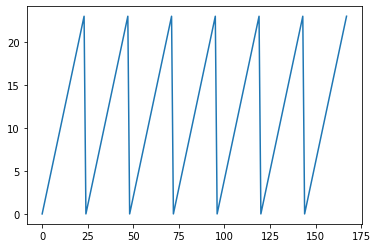

In [9]:
ax = sample['Hour'].plot()

In [10]:
df = encode(df, 'month', 12)
df = encode(df, 'Hour', 24)
df = encode(df, 'weekday', 7)

Here we see exactly what we would expect from hourly data for a week: a cycle between 0 and 23 that repeats 7 times.

This graph also illustrates the problem with presenting cyclical data to a machine learning algorithm: there are jump discontinuities in the graph at the end of each day, when the hour value goes from  23  to  00 .

Let's have a look at the time period around midnight of the first day

## Encoding Cyclical Features

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:

xsin=sin(2∗π∗xmax(x)) 

xcos=cos(2∗π∗xmax(x)) 

In [11]:
sample = df[0:168]

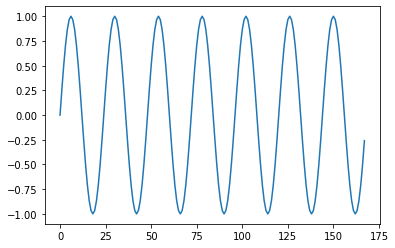

In [12]:
ax = sample['Hour_sin'].plot()

Great, it appears the absolute difference an hour_sin before, at and after midnight is now the same! However, if we look at the plot of hour_sin (following any flat line intersection with the graph), we can see there is a problem. If we consider just the one dimension, there are two records with exactly the same hour_sin values, e.g. records 11 and 25.

This is why we also need the cosine transformation, to separate these records from each other.

Indeed, if we plot both features together in two dimensions we get the following:

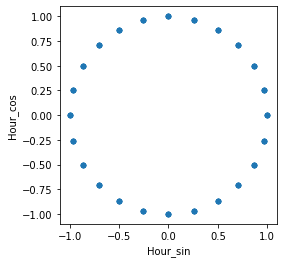

In [13]:
ax = sample.plot.scatter('Hour_sin', 'Hour_cos').set_aspect('equal')

Exactly what we want: our cyclical data is encoded as a cycle. Perfect for presenting to deep learning algorithm.

# Categorical features : One hot encoding

In [104]:
df = pd.get_dummies(df,columns=['Hour', 'Seasons', 'month', 'weekday_name'],drop_first=True)

# Standard Scaler

In [19]:
numerical_columns = ['Temp', 'Humidity', 'Windspeed', 'Dew Point', 'Solar Radiation',
       'Inverse_Visibility', 'Snowing', 'Dryness']

# Train-test split

In [105]:
X, y = df.drop('RBC', axis=1), df['RBC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (5819, 56)
y_train shape: (5819,)
X_test shape: (2494, 56)
y_test shape: (2494,)


# Feature Selection

Permutation Based Feature Importance

In [106]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

perm_importance = permutation_importance(rf, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

In [107]:
sorted_idx = sorted_idx[-20:] # store top 3 indices

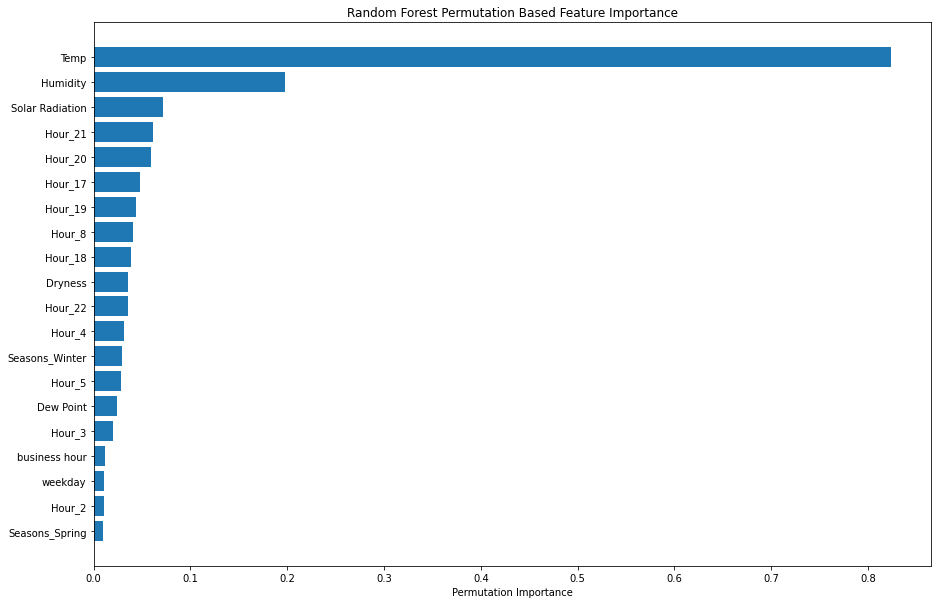

In [108]:
plt.figure(figsize=(15,10))
plt.title("Random Forest Permutation Based Feature Importance")
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig('./img/_Fs_permut.jpg', dpi=300)

SelectKBest

In [109]:
fs = SelectKBest(score_func=f_regression, k=15)
fs.fit(X, y)

SelectKBest(k=15, score_func=<function f_regression at 0x7f8831b70c10>)

In [110]:
feature_contribution = (fs.scores_/sum(fs.scores_))*100

In [111]:
for i,j in enumerate(X.columns):
    print(f'{j} : {feature_contribution[i]:.2f}%')

Temp : 26.20%
Humidity : 2.29%
Windspeed : 1.05%
Dew Point : 10.73%
Solar Radiation : 5.49%
Inverse_Visibility : 2.49%
Snowing : 2.44%
Dryness : 2.82%
Holiday : 0.24%
business hour : 0.71%
is_weekend : 0.01%
year : 3.30%
weekday : 0.01%
Hour_1 : 0.45%
Hour_2 : 1.05%
Hour_3 : 1.70%
Hour_4 : 2.29%
Hour_5 : 2.23%
Hour_6 : 1.13%
Hour_7 : 0.03%
Hour_8 : 0.83%
Hour_9 : 0.00%
Hour_10 : 0.15%
Hour_11 : 0.04%
Hour_12 : 0.01%
Hour_13 : 0.03%
Hour_14 : 0.06%
Hour_15 : 0.19%
Hour_16 : 0.49%
Hour_17 : 1.51%
Hour_18 : 1.07%
Hour_19 : 1.04%
Hour_20 : 0.85%
Hour_21 : 0.92%
Hour_22 : 0.49%
Hour_23 : 0.00%
Seasons_Spring : 0.03%
Seasons_Summer : 4.47%
Seasons_Winter : 15.86%
month_2 : 1.15%
month_3 : 0.09%
month_4 : 0.05%
month_5 : 0.30%
month_6 : 0.69%
month_7 : 0.68%
month_8 : 0.18%
month_9 : 0.22%
month_10 : 0.32%
month_11 : 0.00%
month_12 : 1.50%
weekday_name_Monday : 0.00%
weekday_name_Saturday : 0.02%
weekday_name_Sunday : 0.09%
weekday_name_Thursday : 0.00%
weekday_name_Tuesday : 0.00%
weekday_na

Not surprisingly, the meteorological feautures are globally the most important ones. The the working hours are following with 18h for instance.

# RFECV

Basically, it uses one of the classification methods, assign weights to each of features. Whose absolute weights are the smallest are pruned from the current set features. That procedure is recursively repeated on the pruned set until the desired number of features

In [112]:
#!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [113]:
def grid_search(X, y, model, param_grid={}):
    rkwargs = {'random_state':42}
    try:
        model(**rkwargs)
    except:
        rkwargs = {}
        
    grid = GridSearchCV(
        model(**rkwargs),
        param_grid=param_grid,
        cv=ShuffleSplit(n_splits=4, random_state=42),
        verbose=0,
        n_jobs=-1
    )

    grid.fit(X, y)
    return grid

In [114]:
param_grid = {
    'max_depth': [10, 50, 100],
    'max_features' : ['auto', 'sqrt'], 
    'n_estimators': [10, 50, 100],
    'criterion': ['mse']
}

In [115]:
model = RandomForestRegressor
grid = grid_search(X_train, y_train, model, param_grid)

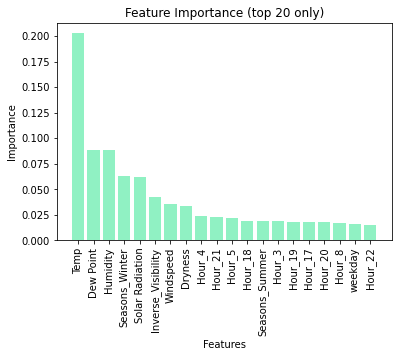

In [116]:
rf_model = grid.best_estimator_
feature_importances = {
    feature: importance
    for feature, importance in zip(X_train.columns, rf_model.feature_importances_)
}
feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:20]}

plt.bar(range(len(feature_importances)), list(feature_importances.values()), align='center', color='#23e589', alpha=0.5)
plt.xticks(range(len(feature_importances)), list(feature_importances.keys()), rotation=90)
plt.title('Feature Importance (top 20 only)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('./img/_Fs_rf_importance.jpg', dpi=300, bbox_inches='tight')
pass

# FUTURE WORK: lag features

In [236]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



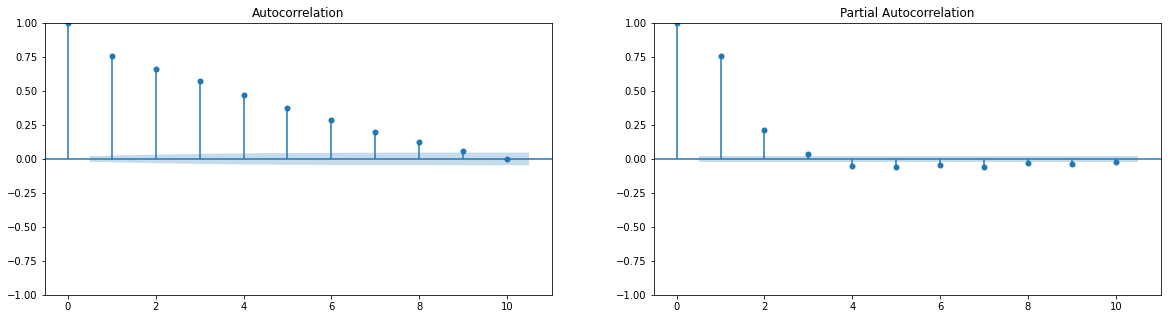

In [237]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
plot_acf(df['Windspeed'],lags = 10,ax=ax[0]);
plot_pacf(df['Windspeed'],lags = 10,ax=ax[1]);

# FUTURE WORK: Model selection